In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import torchvision.transforms as T


class PositionalNoiseEmbedding(nn.Module): # positional embedding based on transformer
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, sigma):
        device = sigma.device # sigma is noise level
        half_dim = self.embedding_dim // 2
        emb = torch.log(torch.tensor(10000.0, device=device)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = sigma[:, None] * emb[None, :]  # (B, half_dim)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)  # (B, embedding_dim)
        return emb

class UNetDDPMpp(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_emb_dim=64):
        super().__init__()
        # Time embedding
        self.time_embed = PositionalNoiseEmbedding(time_emb_dim)
        self.time_emb_proj1 = nn.Linear(time_emb_dim, out_channels)
        self.time_emb_proj2 = nn.Linear(time_emb_dim, out_channels)
        self.time_emb_proj3 = nn.Linear(time_emb_dim, out_channels * 2)
    
        #encoder
        self.encoder1 = self.convolution_block(in_channels, out_channels)
        self.encoder2 = self.convolution_block(out_channels, out_channels*2)

        # Bottleneck
        self.bottleneck = self.convolution_block(out_channels * 2, out_channels * 4)

        #decoder
        self.decoder2 = self.up_block(out_channels * 4, out_channels * 2)
        self.decoder1 = self.up_block(out_channels * 2, out_channels)

        # Final output
        self.last_conv = nn.Conv2d(out_channels, 3, kernel_size=1)

    def convolution_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def up_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
            self.convolution_block(out_c * 2, out_c)
        )  
    
    def forward(self, x, c_noise):
        t_emb = self.time_embed(c_noise.view(-1)) # [batch, time_emb_dim]

        # Inject time embedding into each stage
        emb1 = self.time_emb_proj1(t_emb).unsqueeze(-1).unsqueeze(-1)  # [B, C, 1, 1]
        emb2 = self.time_emb_proj2(t_emb).unsqueeze(-1).unsqueeze(-1)
        emb3 = self.time_emb_proj3(t_emb).unsqueeze(-1).unsqueeze(-1)

        enc1 = self.encoder1(x + emb1)

        enc2 = self.encoder2(F.max_pool2d(enc1, 2) + emb2)
        
        b = self.bottleneck(F.max_pool2d(enc2, 2) + emb3)

        d2 = self.decoder2[0](b)
        d2 = self.decoder2[1](torch.cat([d2, enc2], dim=1))

        d1 = self.decoder1[0](d2)
        d1 = self.decoder1[1](torch.cat([d1, enc1], dim=1))

        return self.last_conv(d1)

class Denoiser(nn.Module):
    def __init__(self, unet ):
        super().__init__()
        self.unet = unet

    def get_precondition(self, sigma, M=1000 ):
        sigma = sigma.view(-1, 1, 1, 1)  # Shape: [B, 1, 1, 1]
        c_skip = torch.ones_like(sigma) 
        c_out = -sigma
        c_in = 1 / (torch.sqrt(sigma**2 + 1))

        beta_d = 19.9
        beta_min = 0.1
        sigma_invert = ((beta_min ** 2 + 2 * beta_d * (1 + sigma ** 2).log()).sqrt() - beta_min) / beta_d
        c_noise = (M - 1) * sigma_invert

        return c_skip, c_out, c_in, c_noise

    def loss(self, x, noise, sigma): # equation 8
        c_skip, c_out, c_in, c_noise = self.get_precondition(sigma)
        noised_input = x + noise*sigma.view(-1, 1, 1, 1)
        model_output = self.unet(c_in*noised_input , c_noise.flatten())
        target = (x - c_skip * noised_input) / c_out
        return ((model_output - target).pow(2)).flatten(1).mean(1)

    def forward(self, x, sigma): # equation 7 EDM paper
        c_skip, c_out, c_in, c_noise = self.get_precondition(sigma)
        return c_skip*x +  c_out * self.unet(c_in*x, c_noise.flatten())

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_sigma_vp(batch_size):
    epsilon_t = 1e-5
    beta_d=19.9
    beta_min=0.1
    t = torch.rand(batch_size) * (1 - epsilon_t) + epsilon_t  # U(epsilon_t, epsilon_1)
    sigma = torch.sqrt(torch.exp(0.5 * beta_d * t**2 + beta_min * t) - 1)
    return sigma


def training(resume_path = None, train_loop=10, lr=2e-4):
    unet_model = UNetDDPMpp()
    denoiser = Denoiser(unet_model)
    optimizer = optim.Adam(denoiser.parameters(), lr)
    
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ])

    dataset = datasets.CIFAR10(root='../data', train=True, download=True,transform=transform)
    loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

     # Load checkpoint 
    if resume_path is not None:
        checkpoint = torch.load(resume_path, map_location='cpu')
        denoiser.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Resumed from checkpoint: {resume_path}, starting at epoch {start_epoch}")

    for epoch in range(train_loop):
        pbar = tqdm(loader)
        total_loss = 0 

        if resume_path is not None: 
            save_path =  f'check_points3/checkpoint_epoch_04_{start_epoch+epoch+1}.pt'
        else:
            save_path =  f'check_points3/checkpoint_epoch_04_{epoch+1}.pt'

        for x, _ in pbar:
            x = x.to(device)
            B = x.size(0)

            sigma = get_sigma_vp(B)
            noise = torch.randn_like(x)

            loss =  denoiser.loss(x, noise, sigma).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_description(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': denoiser.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
        }, save_path)

    print(f"[Epoch {epoch+1}] Avg Loss: {total_loss / len(loader):.4f}")
    

In [ ]:
# training( train_loop=100)


In [ ]:
def sigma_fn(t,beta_d=19.9, beta_min=0.1 ):
    return  torch.sqrt(torch.exp(0.5 * beta_d * t ** 2 + beta_min * t) - 1) # Example
def s_fn(t,beta_d=19.9, beta_min=0.1 ):
    return  1 / (torch.sqrt(torch.exp(0.5 * beta_d * t ** 2 + beta_min * t)))

def dsigma_t(t, beta_d=19.9, beta_min=0.1):
    exp_term = torch.exp(0.5 * beta_d * t**2 + beta_min * t)
    return 0.5 * (beta_d * 2 * t + beta_min) * exp_term / (2 * torch.sqrt(exp_term - 1))

def ds_t(t, beta_d=19.9, beta_min=0.1):
    exp_term = torch.exp(0.5 * beta_d * t**2 + beta_min * t)
    ds = -0.5 * (2 * beta_d * t + beta_min) * exp_term / (exp_term ** 1.5)
    return ds

def heun_sampler(denoiser, sigma_fn, s_fn, t_steps, shape, device):
    t0 = t_steps[0].detach().clone().requires_grad_()
    sigma0 = sigma_fn(t0)
    s0 = s_fn(t0)
    x = torch.randn(shape, device=device) * sigma0 + torch.zeros(shape, device=device) * s0

    N = len(t_steps) - 1
    for i in range(N):
        t_i = t_steps[i].detach().clone().requires_grad_()
        t_i1 = t_steps[i + 1].detach().clone().requires_grad_()

        sigma_i = sigma_fn(t_i)
        s_i = s_fn(t_i)

        sigma_ip = dsigma_t(t_i)
        s_ip = ds_t(t_i)

        D_i = denoiser(x / s_i, sigma_i)
        d_i = (sigma_ip / sigma_i + s_ip / s_i) * x - (sigma_ip * s_i / sigma_i) * D_i

        x_next = x + (t_i1 - t_i) * d_i

        if sigma_fn(t_i1) != 0:
            sigma_i1 = sigma_fn(t_i1)
            s_i1 = s_fn(t_i1)

            sigma_ip1 = dsigma_t(t_i1)
            s_ip1 = ds_t(t_i1)

            D_ip1 = denoiser(x_next / s_i1, sigma_i1)
            d_ip1 = (sigma_ip1 / sigma_i1 + s_ip1 / s_i1) * x_next - \
                    (sigma_ip1 * s_i1 / sigma_i1) * D_ip1

            x_next = x + (t_i1 - t_i) * 0.5 * (d_i + d_ip1)

        x = x_next

    return x

def get_t_steps(steps=1000, epsilon_s=1e-3):
    return torch.linspace(1.0, epsilon_s, steps)
t_steps = get_t_steps(300)

model2 = UNetDDPMpp().to(device)
denoiser2 = Denoiser(model2) 

checkpoint = torch.load("check_points3/checkpoint_epoch_03_40.pt", map_location=device)
denoiser2.load_state_dict(checkpoint['model_state_dict'])
denoiser2.eval()

shape = (128, 3, 32, 32)  # example batch
# temp = heun_sampler(denoiser2, sigma_fn, s_fn, t_steps, shape, device=device)

In [ ]:
def print_sample_img(img):
    sample_clamped = img.clamp(-1, 1)  # clamp values to [-1, 1] just in case
    sample_normalized = (sample_clamped + 1) / 2
    img_output = sample_normalized[0].permute(1, 2, 0).detach().cpu().numpy()

    plt.imshow(img_output)
    plt.axis('off')
    plt.title("Sampled Image")
    plt.show()

# print_sample_img(temp)

In [ ]:
# this is to test how the schedule distort the clean image data distribution
def simulate_vp_sde(x0, steps=100, beta_min=0.1, epsilon_s = 0.001, beta_d = 19.9):
    
    x = x0.clone()
    dt = 1.0 / steps
    images = [x0.cpu()] 

    for i in range(steps):
        sigma = get_sigma_vp(1).view(1, 1, 1, 1)  # shape match
        noise = torch.randn_like(x0)
        x_noisy = x0 + sigma * noise

        images.append(x_noisy.cpu())

    return images
def show_images(images, every=10):
    n = len(images)
    indices = list(range(0, n, every))
    fig, axs = plt.subplots(1, len(indices), figsize=(15, 3))
    for ax, i in zip(axs, indices):
        img = images[i][0].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min()) 
        ax.imshow(img)
        ax.set_title(f"Step {i}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def print_img_fwd_process(img):
    transform = T.Compose([
        T.Resize((128, 128)),        
        T.ToTensor(),            
        T.Normalize(0.5, 0.5)      
    ])
    x0 = transform(img).unsqueeze(0).to(device)

    noisy_mg = simulate_vp_sde(x0, steps=100)
    show_images(noisy_mg, every=10)

img = Image.open('../cat.jpg')
print_img_fwd_process(img)


In [ ]:
# This code is copied to measure FID score
# It is not in scope of implementation

from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from torchvision.utils import save_image
import os

unet = UNetDDPMpp()
model = Denoiser(unet)

checkpoint = torch.load('check_points3/checkpoint_epoch_03_40.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Sampling parameters
num_images = 1000
batch_size = 128
output_dir = 'fid-out/images'
os.makedirs(output_dir, exist_ok=True)

for i in tqdm(range(0, num_images, batch_size)):
    current_batch_size = min(batch_size, num_images - i)
    noise = torch.randn(current_batch_size, 3, 32, 32)
    
    with torch.no_grad():
        samples = heun_sampler(model, sigma_fn, s_fn, get_t_steps(),(current_batch_size,3,32,32) ,device=device)
    
    samples = (samples.clamp(-1, 1) + 1) / 2
    
    for j in range(current_batch_size):
        if j%50 == 0:
            save_image(samples[j], os.path.join(output_dir, f'{i + j:05d}.png'))


def load_images_from_dir(directory, image_size=299):
    images = []
    tf = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])
    for filename in tqdm(os.listdir(directory)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(os.path.join(directory, filename)).convert('RGB')
            images.append(tf(img))
    return torch.stack(images)

@torch.no_grad()
def get_inception_activations(images, batch_size=64):
    model = inception_v3(pretrained=True, transform_input=False).eval()
    model.fc = torch.nn.Identity()  # Get feature vector before classification
    activations = []

    for i in tqdm(range(0, len(images), batch_size)):
        batch = images[i:i+batch_size]
        pred = model(batch)
        activations.append(pred.cpu().numpy())
    
    return np.concatenate(activations, axis=0)

def calculate_fid(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)

def compute_fid(image_dir, ref_stats_path, batch_size=64):
    print("Loading generated images...")
    images = load_images_from_dir(image_dir)
    print(f"Loaded {len(images)} images.")

    print("Extracting Inception features...")
    feats = get_inception_activations(images, batch_size)
    mu, sigma = np.mean(feats, axis=0), np.cov(feats, rowvar=False)

    print("Loading reference statistics...")
    ref = np.load(ref_stats_path)
    mu_ref, sigma_ref = ref['mu'], ref['sigma']

    print("Computing FID...")
    fid = calculate_fid(mu, sigma, mu_ref, sigma_ref)
    print(f"FID: {fid:.4f}")
    return fid

compute_fid(
    image_dir="fid-out/images",
    ref_stats_path="fid-refs/cifar10-32x32.npz",  # downloaded .npz from NVIDIA
    batch_size=64
)

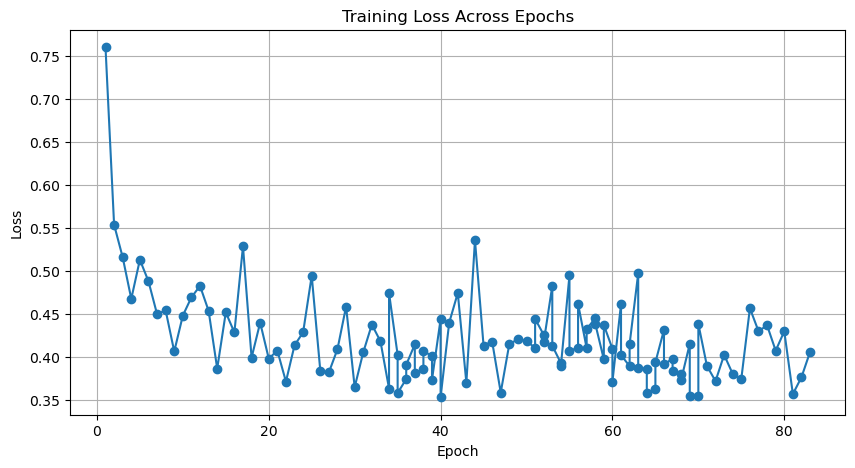

In [ ]:
# to plot the training loss

import re

def extract_run_and_epoch(filename):
    match = re.search(r'checkpoint_epoch_(\d+)_(\d+)', filename)
    if match:
        run = int(match.group(1))
        epoch = int(match.group(2))
        global_epoch = epoch
        return global_epoch, run, epoch
    return (-1, -1, -1)

checkpoint_dir = "check_points3/"
checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith("checkpoint_epoch_")]
checkpoints_sorted = sorted(checkpoints, key=lambda x: extract_run_and_epoch(x)[0])

global_epochs = []
losses = []

for ckpt in checkpoints_sorted:
    path = os.path.join(checkpoint_dir, ckpt)
    ckpt_data = torch.load(path, map_location='cpu')
    global_epoch, run, epoch = extract_run_and_epoch(ckpt)
    
    global_epochs.append(global_epoch)
    losses.append(ckpt_data['loss'])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(global_epochs, losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Across Epochs")
plt.grid(True)
plt.show()
